We want to implement FE$^2$ method using `Fenicsx` and `Spectral` methods.

Importing `Fenicsx` related modules. 

In [1]:
import dolfinx as df
import ufl
import basix
from mpi4py import MPI

from pathlib import Path
from typing import Dict

cache_dir = f"/cluster/scratch/mpundir/dolfinx-cache/"
print(f"Directory to put C files in: {cache_dir}")

jit_options = {"cffi_extra_compile_args":  ["-O3", "-march=native"],
                "cache_dir": cache_dir, "cffi_libraries": ["m"]}

Directory to put C files in: /cluster/scratch/mpundir/dolfinx-cache/


Importing `Jax` related modules

In [2]:
import jax
jax.config.update("jax_compilation_cache_dir", "/cluster/scratch/mpundir/jax-cache")
import jax.numpy as jnp
jax.config.update("jax_enable_x64", True)  # use double-precision
jax.config.update('jax_platforms', 'cpu')
from jax.typing import ArrayLike
from jax import Array
import functools

Importing `Spectral` methods helpers

In [3]:
import sys
sys.path.append('../fft_helpers/')
from projection_operators import compute_Ghat_4_2
import tensor_operators as tensor

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.morphology import disk, rectangle

## macroscale problem

We define a rectangular domain at `macro` scale. 

In [5]:
length, height = 1.0, 1.0
Nx, Ny = 2, 2
domain = df.mesh.create_rectangle(
    MPI.COMM_WORLD,
    [np.array([0, 0]), np.array([length, height])],
    [Nx, Ny],
    cell_type=df.mesh.CellType.triangle,
)

dim = domain.topology.dim
print(f"Mesh topology dimension d={dim}.")

Mesh topology dimension d=2.


We use `Lagrange` shape functions of `degree=1` at the macro scale to interpolate displacement fields. 

In [6]:
gdim = domain.geometry.dim

deg_u = 1
shape = (gdim,)
V = df.fem.functionspace(domain, ("P", deg_u, shape))

In [7]:
V_ux, _ = V.sub(0).collapse()
V_uy, _ = V.sub(1).collapse()
left_dofs = df.fem.locate_dofs_geometrical(
    (V.sub(0), V_ux), lambda x: np.isclose(x[0], 0.0)
)
bot_dofs = df.fem.locate_dofs_geometrical(
    V, lambda x: np.isclose(x[1], 0.0)
)
top_dofs = df.fem.locate_dofs_geometrical(
    (V.sub(1), V_uy), lambda x: np.isclose(x[1], height)
)

uD_x0 = df.fem.Function(V_ux)
uD_y0 = df.fem.Function(V_uy)
uD_y = df.fem.Function(V_uy)
epsr = 1e-1
uD_y.vector.set(epsr * height)
bcs = [
    #df.fem.dirichletbc(uD_x0, left_dofs, V.sub(0)),
    df.fem.dirichletbc(np.zeros((2, )), bot_dofs, V),
    df.fem.dirichletbc(uD_y, top_dofs, V.sub(1)),
]

In [8]:
deg_quad = 1  # quadrature degree for internal state variable representation

dx = ufl.Measure(
    "dx",
    domain=domain,
    metadata={"quadrature_degree": deg_quad, "quadrature_scheme": "default"},
)
ds = ufl.Measure('ds', domain=domain, 
                 metadata={"quadrature_degree": deg_quad, "quadrature_scheme": "default"})



We also need function spaces for stresses and tangent matrix. To this end, we define 

In [22]:
vdim = 3 + 1  # dimension of the full vectorial representation of tensors
W0e = basix.ufl.quadrature_element(
    domain.basix_cell(), value_shape=(), scheme="default", degree=deg_quad
)

We = basix.ufl.quadrature_element(
    domain.basix_cell(), value_shape=(vdim, ), scheme="default", degree=deg_quad
)
WTe = basix.ufl.quadrature_element(
    domain.basix_cell(), value_shape=(vdim,vdim), scheme="default", degree=deg_quad
)


W = df.fem.functionspace(domain, We)
WT = df.fem.functionspace(domain, WTe)
W0 = df.fem.functionspace(domain, W0e)


sig = df.fem.Function(W, name="Stress")
Ct = df.fem.Function(WT, name="Tangent_operator")
eps = df.fem.Function(W, name="Total_strain")
eps_old = df.fem.Function(W, name="Previous_total_strain")

u = df.fem.Function(V, name="Total_displacement")
du = df.fem.Function(V, name="Iteration_correction")
v = ufl.TrialFunction(V)
u_ = ufl.TestFunction(V)

In [24]:
def gradu(v):
    F = ufl.grad(v)
    return ufl.as_tensor([F[0, 0], F[0, 1], F[1, 0], F[1, 1]])


residual_form = ufl.dot(gradu(u_), sig) * dx
tangent_form = ufl.dot(gradu(v), ufl.dot(Ct, gradu(u_))) * dx

In [25]:
basix_celltype = getattr(basix.CellType, domain.topology.cell_type.name)
quadrature_points, weights = basix.make_quadrature(basix_celltype, deg_quad)

map_c = domain.topology.index_map(domain.topology.dim)
num_cells = map_c.size_local + map_c.num_ghosts
cells = np.arange(0, num_cells, dtype=np.int32)
ngauss = num_cells * len(weights)

eps_expr = df.fem.Expression(gradu(u), quadrature_points)


def eval_at_quadrature_points(expression):
    return expression.eval(domain, cells).reshape(ngauss, -1)

## microscale problem using spectral method

We now define the microscale problem. We define a local microstructure with a inclusion. This micorstructure will be defined for each `gauss` point. The strains from the macro scale at each gauss point will be passed to each microstructure and from the microstructure the average stress and a tangent stiffness matrix is passed to the macroscale.  

![Multiscale schematic](FE2-schematic.png)

We choose FFT based spectral method to solve the microstructure and get the local stresses as well as macro stress. To get the tangent stiffness matrix, we make use of the `jax` library and use the automatic differentation to compute the eact tangent operator.

Please check the folowing link for my inspiration
- [JAX](https://jax.readthedocs.io/en/latest/)
- [Fenicsx inspiration](https://bleyerj.github.io/comet-fenicsx/tours/nonlinear_problems/linear_viscoelasticity_jax/linear_viscoelasticity_jax.html)
- [More possiblity](https://github.com/a-latyshev/dolfinx-external-operator)

Now, we define the microscale RVE.

In [26]:
# material parameters
elastic_modulus = {"solid": 5.7, "inclusion": 5.7}  # N/mm2
poisson_modulus = {"solid": 0.386, "inclusion": 0.386}


In [27]:
structure = np.load('./figs/blurred_lattice.npy')
structure = np.where(structure < 0.6, 0, 1)
H, L = structure.shape
size = np.minimum(H, L)
if size%2 == 0:
    size = size-1
structure = structure[:size, :size]

In [28]:
length = 1.
H, L = structure.shape
dx = length/H
dy = length/L

In [29]:
ndim = len(structure.shape)
N = structure.shape[0]

# grid dimensions
shape = [
    N,
] * ndim  # number of voxels in all directions

In [30]:
cb = plt.imshow(structure, origin="lower", cmap='Greys')
plt.colorbar(cb)
plt.show()

We also define certain Identity tensor for each grid point.

- $\mathbf{I}$ = 2 order Identity tensor with shape `(2, 2, N, N)` 
- $\mathbb{I4}$ = 4 order Identity tensor with shape `(2, 2, 2, 2, N, N)`


## fft helpers and operators

In [31]:
# identity tensor (single tensor)
i = jnp.eye(ndim)

# identity tensors (grid)
I = jnp.einsum(
    "ij,xy",
    i,
    jnp.ones(
        [
            N,
        ]
        * ndim
    ),
)  # 2nd order Identity tensor
I4 = jnp.einsum(
    "ijkl,xy->ijklxy",
    jnp.einsum("il,jk", i, i),
    jnp.ones(
        [
            N,
        ]
        * ndim
    ),
)  # 4th order Identity tensor
I4rt = jnp.einsum(
    "ijkl,xy->ijklxy",
    jnp.einsum("ik,jl", i, i),
    jnp.ones(
        [
            N,
        ]
        * ndim
    ),
)
I4s = (I4 + I4rt) / 2.0

II = tensor.dyad22(I, I)
I4d = I4s - II / 3.0

In [32]:
# (inverse) Fourier transform (for each tensor component in each direction)
@jax.jit
def fft(x):
    return jnp.fft.fftshift(jnp.fft.fftn(jnp.fft.ifftshift(x), [N, N]))

@jax.jit
def ifft(x):
    return jnp.fft.fftshift(jnp.fft.ifftn(jnp.fft.ifftshift(x), [N, N]))

The projection operator

In [33]:
Ghat4_2 = compute_Ghat_4_2(NN=(N,) * ndim, operator="fourier", length=1.0)

In [34]:
# material parameters + function to convert to grid of scalars
@functools.partial(jax.jit, static_argnames=['ones', 'zeros'])
def param(X, ones, zeros):
    return ones*jnp.ones_like(X)*(X)+zeros*jnp.ones_like(X)*(1-X)

In [35]:
# lames constant
lambda_modulus = {}
shear_modulus = {}
bulk_modulus = {}

for key in elastic_modulus.keys():
    lambda_modulus[key] = (
        poisson_modulus[key]
        * elastic_modulus[key]
        / ((1 + poisson_modulus[key]) * (1 - 2 * poisson_modulus[key]))
    )

    shear_modulus[key] = elastic_modulus[key] / (2 * (1 + poisson_modulus[key]))

    bulk_modulus[key] = lambda_modulus[key] + 2 * shear_modulus[key] / 3

In [36]:
# material parameters
K      = param(structure,   ones=bulk_modulus['inclusion'],            zeros=bulk_modulus['solid']        )  # bulk      modulus
μ0     = param(structure,   ones=shear_modulus['inclusion'],           zeros=shear_modulus['solid']        )  # shear     modulus
λ0     = param(structure,   ones=lambda_modulus['inclusion'],          zeros=lambda_modulus['solid']        )  # shear     modulus

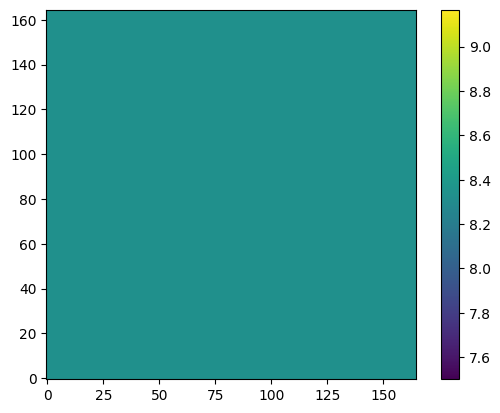

In [37]:
plt.imshow(K, origin='lower')
plt.colorbar()

## st-venant kirchhoff material

The strain energy function for a `St. Venant Kirchhoff` material (isotropic compresisble hyperelastic material) is given as 
\begin{align}
\psi(E) &= \dfrac{\lambda}{2}(\text{tr} E)^2 + \mu \text{tr}(E:E) \\ 
\end{align}

where `E= Green-Lagrange strain tensor` which can be related to the `deformation gradient F` as 
\begin{align}
E = \dfrac{1}{2}(F^{T}.F -I)
\end{align}

In [38]:
@jax.jit
def green_lagrange_strain(F : ArrayLike) -> Array:
    return .5*(tensor.dot22(tensor.trans2(F),F)-I)

@jax.jit
def strain_energy(F : ArrayLike) -> Array:
    E = green_lagrange_strain(F)
    E = 0.5*(E + tensor.trans2(E))
    energy = 0.5 * jnp.multiply(λ0, tensor.trace2(E)**2) + jnp.multiply(μ0, tensor.trace2(tensor.dot22(E, E)))
    return energy.sum()

piola_kirchhoff = jax.jit(jax.jacrev(strain_energy))

Due to the `geometric nonlinearity` in the stress-strain relationship, we use a `Netwon-Raphson` scheme combined with `Conjugate gradient` to solve for the compatible strains within the RVE. 
\begin{align}
    \Delta \sigma_{ij} = \dfrac{\partial \sigma_{ij}(F)}{\partial F_{ij}}\Delta F_{ij}
\end{align}

In [39]:
# functions for the projection 'G', and the product 'G : K : dF'
@jax.jit
def G(A2):
    return  jnp.real( ifft( tensor.ddot42(Ghat4_2,fft(A2)) ) ).reshape(-1)

In [40]:
@functools.partial(jax.jit, static_argnames=['piola_kirchhoff'])
def G_P(dF, F, piola_kirchhoff):
    dF = dF.reshape(ndim,ndim,N,N)
    tangents = jax.jvp(piola_kirchhoff, (F,), (dF,))[1] ## to compute the jvp at F in the direction of dF to get the correct incremental stress
    return G(tangents)

## newton-krylov solver

Here we define a function to solve the hyperelasticity problem using a `newton-raphson` method and and a `krylov` solver such as `conjugate gradient`

In [41]:
@functools.partial(jax.jit, static_argnames=['A', 'K'])
def conjugate_gradient(A, b, additional, K,  atol=1e-5):

    b, additional = jax.device_put((b, additional))

    def body_fun(state):
        b, p, r, rsold, x =  state
        Ap = A(p, additional, K) 
        alpha = rsold / jnp.vdot(p, Ap)
        x = x + jnp.dot(alpha, p)
        r = r - jnp.dot(alpha, Ap)
        rsnew = jnp.vdot(r, r) 
        p = r + (rsnew/rsold)*p
        rsold = rsnew
        return (b, p, r, rsold, x)

    def cond_fun(state):
        b, p, r, rsold, x = state
        return jnp.sqrt(rsold) > atol

    x = jnp.zeros_like(b)
    r = b - A(x, additional, K)
    p = r
    rsold = jnp.vdot(r, r) 

    b, p, r, rsold, x = jax.lax.while_loop(cond_fun, body_fun, (b, p, r, rsold, x) )
    return x

In [42]:
@jax.jit
def solve_netwon_raphson(state, n):
    dF, b, F, Fn = state

    error = jnp.linalg.norm(dF)/Fn
    jax.debug.print('residual={}', error)
       
    def true_fun(state):
        dF, b, F, Fn = state
        #P, P_jvp = jax.linearize(piola_kirchhoff, F)

        dF = conjugate_gradient(
                atol=1e-6, 
                A = G_P,
                b = b,
                additional = F,
                K = piola_kirchhoff,
        )                                   # solve linear system using CG

        dF     = dF.reshape(ndim,ndim,N,N)
        F      = jax.lax.add(F, dF)         # update DOFs (array -> tens.grid)
        P      = piola_kirchhoff(F)         # new residual stress
        b      = -G(P)                      # convert residual stress to residual

        return (dF,  b, F, Fn)

    def false_fun(state):
        return state

    return jax.lax.cond(error > 1e-5, true_fun, false_fun, state), n

In [50]:
@jax.jit
def local_constitutive_update(macro_strain):

    # ----------------------------- NEWTON ITERATIONS -----------------------------
    # initialize stress and strain tensor                         [grid of tensors]
    eps  =  jnp.array(I, copy=True)  # to convert grad u to deformaiton gradient

    # set macroscopic loading
    DE       = jnp.zeros([ndim,ndim,N,N])
    DE = DE.at[0, 0].set(macro_strain[0])
    DE = DE.at[0, 1].set(macro_strain[1])
    DE = DE.at[1, 0].set(macro_strain[2])
    DE = DE.at[1, 1].set(macro_strain[3])

    # initial residual: distribute "DE" over grid using "K4"
    b        = -G_P(DE, eps, piola_kirchhoff)
    eps      = jax.lax.add(eps, DE) 
    En       = jnp.linalg.norm(eps)

    state = (DE, b, eps, En)
    initial_state = jax.device_put(state)

    final_state, xs = jax.lax.scan(solve_netwon_raphson, 
                               init=initial_state, 
                               xs=jnp.arange(0, 10))
    

    DE, b, eps, En = final_state
    P = piola_kirchhoff(eps)

    # get the macro stress
    macro_sigma = jnp.array([jnp.mean(P.at[0, 0].get()), jnp.mean(P.at[0, 1].get()), jnp.mean(P.at[1, 0].get()),  jnp.mean(P.at[1, 1].get())])
    
    return macro_sigma, (macro_sigma, P, eps)

In [64]:
tangent_operator_and_state = jax.jit(jax.jacfwd(
    local_constitutive_update, argnums=0, has_aux=True
))

In [68]:
deps = jnp.array([1e-3, 2e-2, 2e-2, 6e-3])

In [69]:
tangent, state = tangent_operator_and_state(deps)

residual=0.02038181100725376
residual=0.0
residual=0.0
residual=0.0
residual=0.0
residual=0.0
residual=0.0
residual=0.0
residual=0.0
residual=0.0


In [70]:
tangent

Array([[11.15460803,  0.26309452,  0.26309452,  7.01208362],
       [ 0.26309452,  2.14204472,  2.07346833,  0.26399639],
       [ 0.26309452,  2.07346833,  2.14204472,  0.26399639],
       [ 7.01208362,  0.26399639,  0.26399639, 11.28638075]],      dtype=float64)

In [73]:
plt.imshow(state[1].at[1, 1].get(), origin='lower')
plt.colorbar()

In [52]:
batched_constitutive_update = jax.jit(
    jax.vmap(tangent_operator_and_state, in_axes=(0))
)

In [53]:
gauss_sigs = np.zeros([ngauss, ndim, ndim, structure.shape[0], structure.shape[1]])
gauss_eps = np.zeros([ngauss, ndim, ndim, structure.shape[0], structure.shape[1]])

In [54]:
def constitutive_update(u, sig, eps_old, gauss_sigs, gauss_eps):
    with df.common.Timer("Constitutive update"):
        eps_values = eval_at_quadrature_points(eps_expr)        
        Ct_values, state = batched_constitutive_update(
            eps_values
        )
        
        sig_values, local_sigs, local_eps = state

        sig.x.array[:] = sig_values.ravel()
        Ct.x.array[:] = Ct_values.ravel()

        gauss_sigs[:] = local_sigs[:]        
        gauss_eps[:] = local_eps[:]

## solving

In [55]:
from solvers import CustomLinearProblem, CustomNewtonSolver

In [56]:
tangent_problem = CustomLinearProblem(
    tangent_form,
    -residual_form,
    u=du,
    bcs=bcs,
    jit_options=jit_options

    #petsc_options={
    #    "ksp_type": "preonly",
    #    "pc_type": "lu",
    #},
)


In [57]:
newton = CustomNewtonSolver(tangent_problem)
newton.callback = constitutive_update

In [58]:
sig.vector.set(0.0)
u.vector.set(0.0)

state = (sig,  eps_old, gauss_sigs, gauss_eps)
niter, converged = newton.solve(u, *state)

residual=0.0
residual=0.0
residual=0.0
residual=0.0
residual=0.0
residual=0.0
residual=0.0
residual=0.0
residual=0.0
residual=0.0
residual=0.0
residual=0.0
residual=0.0
residual=0.0
residual=0.0
residual=0.0
residual=0.0
residual=0.0
residual=0.0
residual=0.0
residual=0.0
residual=0.0
residual=0.0
residual=0.0
residual=0.0
residual=0.0
residual=0.0
residual=0.0
residual=0.0
residual=0.0
residual=0.0
residual=0.0
residual=0.0
residual=0.0
residual=0.0
residual=0.0
residual=0.0
residual=0.0
residual=0.0
residual=0.0
residual=0.0
residual=0.0
residual=0.0
residual=0.0
residual=0.0
residual=0.0
residual=0.0
residual=0.0
residual=0.0
residual=0.0
residual=0.0
residual=0.0
residual=0.0
residual=0.0
residual=0.0
residual=0.0
residual=0.0
residual=0.0
residual=0.0
residual=0.0
residual=0.0
residual=0.0
residual=0.0
residual=0.0
residual=0.0
residual=0.0
residual=0.0
residual=0.0
residual=0.0
residual=0.0
residual=0.0
residual=0.0
residual=0.0
residual=0.0
residual=0.0
residual=0.0
residual=0.0

In [59]:
plt.figure(figsize=(4, 4))
plt.imshow(gauss_sigs[0][0, 1], origin='lower')
plt.colorbar()
plt.show()

In [60]:
u_topology, u_cell_types, u_geometry = df.plot.vtk_mesh(V)
x = u_geometry
tricells = u_topology.reshape((-1,4))[:, 1:]
u_mat = u.x.array.reshape(-1, 2)

plt.triplot(x[:,0]+ u_mat[:, 0], x[:,1]+ u_mat[:, 1], tricells, zorder=10, color='k', linewidth=0.5 )
plt.tricontourf(x[:,0] + u_mat[:, 0], x[:,1] + u_mat[:, 1], tricells,  u_mat[:, 1])
plt.colorbar()
plt.show()

In [61]:
sig.x.array

array([ 0.6273509 , -0.17359736, -0.12713644,  1.07018995, -0.02679122,
        0.00437495,  0.00179425,  0.64600649,  0.6361974 ,  0.01505335,
        0.01097168,  1.10047111,  0.17828053, -0.02210805, -0.02107047,
        1.05091373,  0.0491704 ,  0.15416906,  0.1151287 ,  0.84866014,
        0.02210805,  0.0210348 ,  0.01731967,  0.9020906 ,  0.09270001,
       -0.01122539, -0.02333173,  0.95546017,  0.01229864,  0.01229864,
        0.01042761,  0.75686318])

In [109]:
gauss_sigs[0][0, 0]

array([[0.61519858, 0.61519858, 0.61519858, ..., 0.61519858, 0.61519858,
        0.61519858],
       [0.61519858, 0.61519858, 0.61519858, ..., 0.61519858, 0.61519858,
        0.61519858],
       [0.61519858, 0.61519858, 0.61519858, ..., 0.61519858, 0.61519858,
        0.61519858],
       ...,
       [0.61519858, 0.61519858, 0.61519858, ..., 0.61519858, 0.61519858,
        0.61519858],
       [0.61519858, 0.61519858, 0.61519858, ..., 0.61519858, 0.61519858,
        0.61519858],
       [0.61519858, 0.61519858, 0.61519858, ..., 0.61519858, 0.61519858,
        0.61519858]])

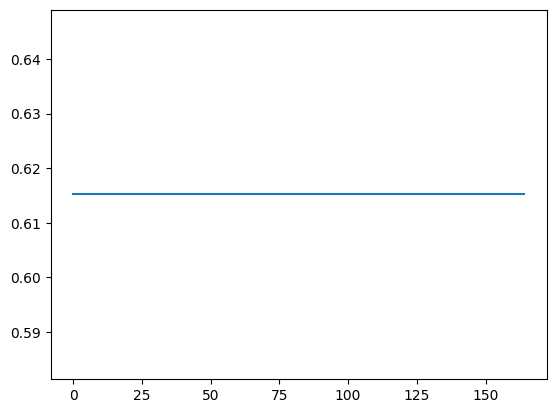

In [152]:
plt.plot(gauss_sigs[0][0, 0][2, :])

In [63]:
df.common.list_timings(MPI.COMM_WORLD, [df.common.TimingType.wall])


[MPI_MAX] Summary of timings                                                |  reps   wall avg   wall tot
---------------------------------------------------------------------------------------------------------
Build dofmap data                                                           |     8   0.000000   0.000000
Build sparsity                                                              |     1   0.000000   0.000000
Compute dof reordering map                                                  |     8   0.000000   0.000000
Compute local part of mesh dual graph                                       |     1   0.000000   0.000000
Compute local-to-local map                                                  |     1   0.000000   0.000000
Compute-local-to-global links for global/local adjacency list               |     1   0.000000   0.000000
Constitutive update                                                         |     5  10.722000  53.610000
Distribute row-wise data (scalable)          

## full scale FEM

In [26]:
v = ufl.TestFunction(V)
u = df.fem.Function(V)

In [27]:
# Spatial dimension
d = len(u)

# Identity tensor
If = ufl.variable(ufl.Identity(d))

# Deformation gradient
F = ufl.variable(If + ufl.grad(u))

# Right Cauchy-Green tensor
C = ufl.variable(F.T * F)

E = ufl.variable(0.5*(C - If))


B = df.fem.Constant(domain, df.default_scalar_type((0, 0)))
T = df.fem.Constant(domain, df.default_scalar_type((0, 0)))

In [28]:
# Elasticity parameters
Y = df.default_scalar_type(elastic_modulus['solid'])
nu = df.default_scalar_type(poisson_modulus['solid'])
mu = df.fem.Constant(domain, Y / (2 * (1 + nu)))
lmbda = df.fem.Constant(domain, Y * nu / ((1 + nu) * (1 - 2 * nu)))

# Stored strain energy density (compressible neo-Hookean model)
psi = 0.5*lmbda*ufl.tr(E)**2 + mu*ufl.tr(E*E)

# Stress
P = ufl.diff(psi, F)


In [29]:
F_form = ufl.inner(ufl.grad(v), P) * dx  - ufl.inner(v, B) * dx  - ufl.inner(v, T) * ds

In [30]:
u.vector.set(0.0)

In [31]:
from dolfinx.fem.petsc import NonlinearProblem

In [32]:
problem = NonlinearProblem(F_form, u, bcs, jit_options=jit_options)

In [33]:
from dolfinx.nls.petsc import NewtonSolver

In [34]:
solver = NewtonSolver(domain.comm, problem)

# Set Newton solver options
solver.atol = 1e-8
solver.rtol = 1e-8
solver.convergence_criterion = "incremental"

In [35]:
solver.solve(u)

(4, True)

In [36]:
u_topology, u_cell_types, u_geometry = df.plot.vtk_mesh(V)
x = u_geometry
tricells = u_topology.reshape((-1,4))[:, 1:]
u_mat = u.x.array.reshape(-1, 2)

plt.triplot(x[:,0]+ u_mat[:, 0], x[:,1]+ u_mat[:, 1], tricells, zorder=10, color='k', linewidth=0.5 )
plt.tricontourf(x[:,0] + u_mat[:, 0], x[:,1] + u_mat[:, 1], tricells,  u_mat[:, 1])
plt.colorbar()
plt.show()

In [94]:
dg2 = basix.ufl.element("DG", domain.topology.cell_name(), 0, shape=(2, 2))
T2 = df.fem.functionspace(domain, dg2)
sigma_h = df.fem.Function(T2, name="Stress")
sigma_expr = df.fem.Expression(P, T2.element.interpolation_points())

sigma_h.interpolate(sigma_expr)

In [110]:
sigma_h.x.array

array([ 0.6273509 , -0.17359736, -0.12713644,  1.07018995, -0.02679122,
        0.00437495,  0.00179425,  0.64600649,  0.6361974 ,  0.01505335,
        0.01097168,  1.10047111,  0.17828053, -0.02210805, -0.02107047,
        1.05091373,  0.0491704 ,  0.15416906,  0.1151287 ,  0.84866014,
        0.02210805,  0.0210348 ,  0.01731967,  0.9020906 ,  0.09270001,
       -0.01122539, -0.02333173,  0.95546017,  0.01229864,  0.01229864,
        0.01042761,  0.75686318])

In [62]:
sig.x.array

array([ 0.6273509 , -0.17359736, -0.12713644,  1.07018995, -0.02679122,
        0.00437495,  0.00179425,  0.64600649,  0.6361974 ,  0.01505335,
        0.01097168,  1.10047111,  0.17828053, -0.02210805, -0.02107047,
        1.05091373,  0.0491704 ,  0.15416906,  0.1151287 ,  0.84866014,
        0.02210805,  0.0210348 ,  0.01731967,  0.9020906 ,  0.09270001,
       -0.01122539, -0.02333173,  0.95546017,  0.01229864,  0.01229864,
        0.01042761,  0.75686318])